In [25]:
import io
import os

import cv2
from google.cloud import vision
from google.cloud.vision_v1 import enums
import matplotlib.pyplot as plt
import pdf2image

In [26]:
PROJECT_PATH = os.getcwd()
GCP_KEY_PATH = str(os.path.join(PROJECT_PATH, "key/gcp_vision_key.json"))

In [27]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = GCP_KEY_PATH

In [28]:
file_path = "./CV_2020-Vizi-Zsolt.pdf"

In [29]:
# Set proper mime_type
mime_type = 'application/pdf'
# Instantiates a client
client = vision.ImageAnnotatorClient()

In [30]:
# Loads the image into memory
with io.open(file_path, 'rb') as f:
    content = f.read()
input_config = {'mime_type': mime_type, 'content': content}

In [31]:
features_element = {'type': enums.Feature.Type.DOCUMENT_TEXT_DETECTION  }
features = [features_element]

# The service can process up to 5 pages per document file
pages = [1]

requests_element = {'input_config': input_config,
                    'features': features, 'pages': pages}
requests = [requests_element]
print("Initialization is complete!")

Initialization is complete!


In [32]:
response = client.batch_annotate_files(requests)
image_responses = response.responses[0].responses

In [33]:
identifier = 0
page_idx = -1
word_collection = []
for image_response in image_responses:
    for page in image_response.full_text_annotation.pages:
        page_idx += 1
        block_idx = -1
        for block in page.blocks:
            block_idx += 1
            if block.block_type == vision.enums.Block.BlockType.TEXT:
                para_idx = -1
                for paragraph in block.paragraphs:
                    para_idx += 1
                    line_idx = 0
                    for ocr_word in paragraph.words:
                        # get word from symbols
                        word_text = ''
                        for symbol in ocr_word.symbols:
                            word_text += symbol.text

                        # get coordinates of the bounding box of the word
                        ocr_bottom_left_coord = ocr_word.bounding_box.normalized_vertices[3]
                        ocr_top_right_coord = ocr_word.bounding_box.normalized_vertices[1]
                        # y coordinate should be transformed y_new = y_image - y_old
                        bottom_left_coord = {"x": ocr_bottom_left_coord.x,
                                             "y": 1.0 - ocr_bottom_left_coord.y}
                        top_right_coord = {"x": ocr_top_right_coord.x,
                                             "y": 1.0 - ocr_top_right_coord.y}

                        # the last symbol of the word contains detected_break
                        break_type = symbol.property.detected_break.type

                        # handle quotation marks by replacing " with \"
                        word_text = word_text.replace('"', '\\"')
                        # create a word instance and add to _wordCollection
                        word_collection.append(
                            {
                                "text": word_text,
                                "bounding_box": {"bottom_left": bottom_left_coord,
                                                 "top_right": top_right_coord},
                                "line": line_idx,
                                "paragraph": para_idx,
                                "identifier": identifier,
                                "confidence": ocr_word.confidence * 100.0,
                                "block_idx": block_idx
                            })
                        identifier += 1

                        if break_type == vision.enums.TextAnnotation.DetectedBreak.BreakType.EOL_SURE_SPACE:
                            # new line
                            line_idx += 1

In [34]:
dpi = 200
formatum = 'jpg'
output_image = pdf2image.convert_from_path(pdf_path=file_path,
                                            dpi=dpi,
                                            output_folder=None,
                                            first_page=None,
                                            last_page=None,
                                            fmt=formatum,
                                            thread_count=1,
                                            userpw=None,
                                            use_cropbox=False,
                                            strict=False)
output_image[0].save("./cv_image.jpg")

In [35]:
img = cv2.imread("./cv_image.jpg")

True

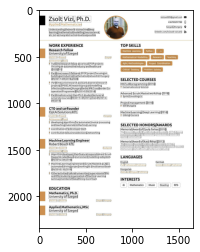

In [36]:
# draw boxes, colored according to confidence of the text
height = img.shape[0]
width = img.shape[1]

for word in word_collection:
    # box coordinates
    margin = 0
    box1_p1 = (
        int(word["bounding_box"]["bottom_left"]["x"] * width) - margin,
        height - int(word["bounding_box"]["bottom_left"]["y"] * height) + margin)
    box1_p2 = (
        int(word["bounding_box"]["top_right"]["x"] * width) + margin,
        height - int(word["bounding_box"]["top_right"]["y"] * height) - margin)

    cv2.rectangle(img=img, pt1=box1_p1, pt2=box1_p2, color=(0,0,0))
plt.imshow(img)
cv2.imwrite("./cv_bounding_box.jpg", img)